In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import matplotlib.pyplot as plt

In [2]:
# Suppress warnings for clean output
warnings.filterwarnings("ignore")

In [3]:
# Load the stock data (ensure it has 'date', 'Name', and 'close' columns)
data = pd.read_csv('./datasets/processed_stock_dataset.csv', parse_dates=['date'])
data=data.drop(columns=['adj_close'])

In [4]:
# Filter stocks that might be correlated or are part of the analysis (e.g., first 50 stocks for demonstration)
stocks_to_include = data['Name'].unique()  # Example subset for faster processing
data = data[data['Name'].isin(stocks_to_include)]
print(stocks_to_include)

['A' 'AAL' 'AAP' 'AAPL' 'ABBV' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP' 'ADSK'
 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AIG' 'AIV' 'AIZ' 'AJG' 'AKAM' 'ALB' 'ALGN'
 'ALK' 'ALL' 'ALLE' 'AMAT' 'AMD' 'AME' 'AMG' 'AMGN' 'AMP' 'AMT' 'AMZN'
 'ANDV' 'ANSS' 'AON' 'AOS' 'APA' 'APD' 'APH' 'APTV' 'ARE' 'AVB' 'AVGO'
 'AVY' 'AWK' 'AXP' 'AYI' 'AZO' 'BA' 'BAC' 'BAX' 'BBY' 'BDX' 'BEN' 'BIIB'
 'BK' 'BLK' 'BMY' 'BSX' 'BWA' 'BXP' 'C' 'CAG' 'CAH' 'CAT' 'CB' 'CBOE'
 'CCI' 'CCL' 'CDNS' 'CF' 'CFG' 'CHD' 'CHRW' 'CHTR' 'CI' 'CINF' 'CL' 'CLX'
 'CMA' 'CMCSA' 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COL' 'COO' 'COP'
 'COST' 'COTY' 'CPB' 'CRM' 'CSCO' 'CSX' 'CTAS' 'CTSH' 'CVS' 'CVX' 'D'
 'DAL' 'DE' 'DFS' 'DG' 'DGX' 'DHI' 'DHR' 'DIS' 'DLR' 'DLTR' 'DOV' 'DRI'
 'DTE' 'DUK' 'DVA' 'DVN' 'DXC' 'EA' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX' 'EL'
 'EMN' 'EMR' 'EOG' 'EQIX' 'EQR' 'EQT' 'ES' 'ESRX' 'ESS' 'ETN' 'ETR' 'EVHC'
 'EW' 'EXC' 'EXPD' 'EXPE' 'EXR' 'F' 'FAST' 'FCX' 'FDX' 'FE' 'FFIV' 'FIS'
 'FITB' 'FL' 'FLR' 'FLS' 'FMC' 'FRT' 'FTI' 'GD' 'GE' 'G

In [5]:
# scaler = StandardScaler()
# data['close_scaled'] = scaler.fit_transform(data[['close']])

In [6]:
scaler = MinMaxScaler()
data['close_scaled'] = scaler.fit_transform(data[['close']])

In [7]:
def create_features(data, lags=3, window=3):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data.groupby('Name')['close_scaled'].shift(lag)
    data[f'rolling_mean_{window}'] = data.groupby('Name')['close_scaled'].transform(lambda x: x.rolling(window).mean())
    data = data.dropna()  # Drop rows with NaN values
    return data

In [8]:
# Apply feature engineering
data = create_features(data, lags=5, window=5)

In [9]:
data['Name'] = data['Name'].astype('category').cat.codes

In [10]:
# Split data into features and target
X = data.drop(columns=['close', 'close_scaled','date','source'])
y = data['close_scaled']

In [11]:
# Train-test split (keeping temporal order intact)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [12]:
# Define XGBoost model
model = XGBRegressor(objective='reg:squarederror', eval_metric="mae", enable_categorical=True)

param_dist = {
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0.5, 1, 1.5, 2],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 150, 200],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 2, 3, 4, 5]
}

In [13]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
# # Manually iterate over parameter combinations to catch errors
# param_sampler = ParameterSampler(param_dist, n_iter=20, random_state=0)
# for params in param_sampler:
#     try:
#         model = XGBRegressor(objective='reg:squarederror', eval_metric="mae", enable_categorical=True)
#         model.fit(X_train, y_train)
#         print(f"Parameters {params} ran successfully.")
#     except Exception as e:
#         print(f"Parameters {params} caused an error: {e}")

In [15]:
# Grid Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_dist, 
    scoring='neg_mean_absolute_error', 
    cv=tscv, 
    n_iter=450, 
    verbose=2, 
    n_jobs=-1
)
random_search.fit(X_train, y_train)
# Best parameters and MAE score
print("Best parameters found: ", random_search.best_params_)
print("Best MAE score: ", -random_search.best_score_)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END alpha=0, colsample_bytree=0.9, gamma=2, lambda=1.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   1.3s
[CV] END alpha=0.5, colsample_bytree=0.7, gamma=4, lambda=2, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   1.4s
[CV] END alpha=0, colsample_bytree=0.9, gamma=2, lambda=1.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.2s
[CV] END alpha=0.5, colsample_bytree=0.7, gamma=4, lambda=2, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   3.0s
[CV] END alpha=0, colsample_bytree=0.9, gamma=2, lambda=1.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END alpha=0.1, colsample_bytree=1.0, gamma=1, lambda=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END alpha=0.5, colsample_bytree=0.7, gamma=4, lambda=2, 

In [ ]:
# Fit final model with best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [ ]:
# Predict and evaluate on test set (inverse scale for interpretability)
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
r2 = r2_score(y_test_actual, y_pred)
print(f"Test Mean Absolute Error (MAE): {mae:.2f}")
print(f"Test Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test Mean Absolute Error (MAE): 0.00
Test Root Mean Squared Error (RMSE): 0.01
Test R² Score: 0.88


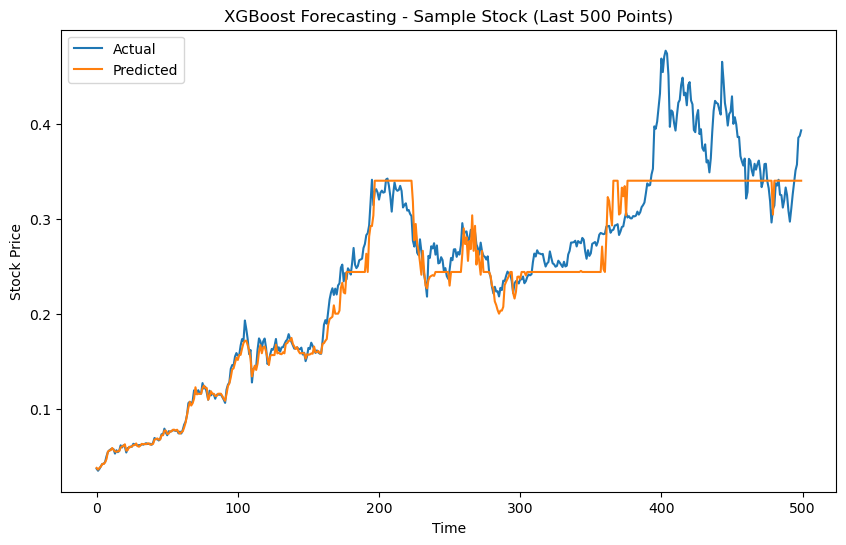

In [ ]:
# Plot a subset for visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[-500:], label='Actual')
plt.plot(y_pred[-500:], label='Predicted')
plt.title("XGBoost Forecasting - Sample Stock (Last 500 Points)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Test Mean Absolute Percentage Error (MAPE): 0.01%


In [ ]:
import pickle

# Save the model to a file
with open("xgboost_stock_forecasting_model.pkl", "wb") as f:
    pickle.dump(best_model, f)